In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
from scipy.ndimage import convolve
import time
from PIL import Image
import os
import ipyplot
import cv2
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from skimage.feature import hog

In [13]:
kernel0 = np.array([
                [-1, 0.0, 1],
                [-2, 0.0, 2],
                [-1, 0.0, 1]])
kernel1= np.array([
                [-1,-2,-1],
                [0.0,0.0,0.0],
                [1,2,1]])

def convolve_img(img, kernel):
    return convolve(img, kernel) 
def brightness(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
def partial_derivative(img):
    grx = convolve_img(img, kernel0)
    gry = convolve_img(img, kernel1)
    return grx, gry
def get_edgeness(img):
    grx, gry = partial_derivative(img)
    edged = [[ 0 for _ in range(len(grx[0]))] for _ in range(len(grx))]
    for i in range(len(grx)):
        for j in range(len(grx[0])):
            edged[i][j] = (abs(grx[i][j])  + abs(gry[i][j]))
    return edged

def least_edgy_ver(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img[0])):
        least_e[-1][i] = edged_img[-1][i]
    m, n = len(edged_img), len(edged_img[0])

    for i in range(m-2,-1,-1):
        for j in range(n):
            j1, j2 = max(0, j-1), min(j+1, n-1)
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(least_e[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            
            least_e[i][j] = edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (j==0)]

    return least_e, dirs

def least_edgy_hor(edged_img):
    least_e = np.zeros_like(edged_img)
    dirs = np.zeros_like(edged_img)
    for i in range(len(edged_img)):
        least_e[i][-1] = edged_img[i][-1]
    m, n = len(edged_img), len(edged_img[0])
    for j in range(n-2, -1, -1):
        for i in range(m):
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(least_e[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            least_e[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction + (i==0)]
    return least_e, dirs


def get_seam_at_ver(dirs, j):
    m = len(dirs)
    js = [0 for _ in range(m)]
    js[0] = j
    for i in range(1, m):
        js[i] = js[i-1]+dirs[i-1][int(js[i-1])]
    return js

def get_seam_at_hor(dirs, i):
    n = len(dirs[0])
    js = [0 for _ in range(n)]
    js[0] = i
    for j in range(1, n):
        js[j] = js[j-1] + dirs[int(js[j-1])][j-1]

    return js

def rm_path_ver(img, path):
    img = np.array(img)
    n = len(img[0])
    cut_img = img[:, :-1].copy()

    for i, j in enumerate(path):
        j = int(j)
        cut_img[i,:j] = img[i,:j]
        cut_img[i,j:] = img[i,j+1:]

    return cut_img

def rm_path_hor(img, path):
    img = np.array(img)
    m = len(img)
    cut_img = img[:-1, :].copy()
    # print(len(cut_img), len(img))
    for i, j in enumerate(path):
        #i is col and j is row here
        j = int(j)
        cut_img[:j,i] = img[:j,i]
        cut_img[j:,i] = img[j+1:,i]

    return cut_img

# def shrink_horizontally(img,edged,org, n):
#     new_img = np.copy(img)
#     org_i = np.copy(org)
#     allDps = []
#     for i in range(n):  
#         dp, dirs = least_edgy_ver(edged)
#         allDps.append(dp)
#         m_col = float('inf')
#         col = 0
#         for j in range(0,len(dp[0])):
#             if m_col > dp[0][j]:
#                 m_col = dp[0][j]
#                 col = j 
#         seam = get_seam_at_ver(dirs, col)
#         new_img = rm_path_ver(new_img, seam)
#         org_i = rm_path_ver(org_i, seam)
#         edged = rm_path_ver(edged, seam)
#     fig, axes = plt.subplots(4, 2, figsize=(25, 15))
#     axes[0][0].imshow(allDps[10])
#     axes[0][1].imshow(allDps[50])
#     axes[1][0].imshow(allDps[75])
#     axes[1][1].imshow(allDps[100])
#     axes[2][0].imshow(allDps[130])
#     axes[2][1].imshow(allDps[140])
#     axes[3][0].imshow(allDps[160])
#     axes[3][1].imshow(allDps[180])


#     return new_img, org_i

# def shrink_vertically(img,edged, n):
#     new_img = np.copy(img)
#     for i in range(n):
#         dp, dirs = least_edgy_hor(edged)
#         m_row = float('inf')
#         row = 0
#         for j in range(0,len(dp)):
#             if m_row > dp[j][0]:
#                 m_row = dp[j][0]
#                 row = j
#         seam = get_seam_at_hor(dirs, row)
#         new_img = rm_path_hor(new_img, seam)
#         edged = rm_path_hor(edged, seam)

#     return new_img
def recompute_dir_neighbours_ver(seam, dirs, dp, edged_img):
    m = len(dp)
    n = len(dp[0])
    for i in range(len(seam)-2, -1,-1):
        j = int(seam[i])
        if j == 0:
            # If we removed 0 column then we have to update 0 column
            j1, j2 = 0, 1
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
                
            dp[i][0] += edged_img[i][0]+min_e
            dirs[i][0] = (0,1)[direction]
        elif j == n:
            j = j-1
            # If we removed n-1 column then we have to update n-1 column
            j1, j2 = j-1, j
            min_e = float('inf')
            direction = 0
            for pi,k in enumerate(dp[i+1][j1:j2+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged_img[i][j] + min_e
            dirs[i][j] = (-1, 0)[direction]
        else:
            if j-1>=0:
                j1, j2 = max(0, j-2), min(j, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j-1] += edged_img[i][j-1] + min_e
                dirs[i][j-1] = (-1,0,1)[direction + ((j-1)==0)]
            if j<n-1:
                j1, j2 = max(0, j-1), min(j+1, n-1)
                min_e = float('inf')
                direction = 0
                for pi,k in enumerate(dp[i+1][j1:j2+1]):
                    if k < min_e:
                        min_e = k
                        direction = pi
                dp[i][j] += edged_img[i][j] + min_e
                dirs[i][j] = (-1,0,1)[direction + (j==0)]
            
            
    return dp, dirs
def recompute_dir_neighbours_hor(seam, dirs, dp, edged):
    m = len(dirs)
    n = len(dirs[0])
    for j in range(len(seam)-2,-1,-1):
        i = int(seam[j])
        if i == 0:
            i1, i2 = 0, 1
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[0][j] += edged[0][j] + min_e
            dirs[0][j] = (0,1)[direction]
        elif i == m:
            i = i-1
            i1, i2 = i-1, i
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0)[direction]
        else:
            i1, i2 = max(0, i-2), min(i, m-1)
            # print(i1, i2, i)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i-1][j] += edged[i-1][j] + min_e
            dirs[i-1][j] = (-1,0,1)[direction+((i-1)==0)]
            i1, i2 = max(0, i-1), min(i+1, m-1)
            min_e = float('inf')
            direction = 0
            for pi, k in enumerate(dp[i1:i2+1,j+1]):
                if k < min_e:
                    min_e = k
                    direction = pi
            dp[i][j] += edged[i][j] + min_e
            dirs[i][j] = (-1,0,1)[direction+(i==0)]
        
    return dp, dirs
def shrink_horizontally(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    new_edged = np.copy(edged)
    dp, dirs = least_edgy_ver(edged)
    allDps = []
    for i in range(n):  
        col = np.argmin(dp[0])
        seam = get_seam_at_ver(dirs, col)
        new_img = rm_path_ver(new_img, seam)
        org_img = rm_path_ver(org_img, seam)
        dp = rm_path_ver(dp, seam)
        dirs = rm_path_ver(dirs, seam)
        # edged = get_edgeness(new_img)
        new_edged = rm_path_ver(new_edged, seam)
        dp, dirs = recompute_dir_neighbours_ver(seam,dirs,dp,new_edged)
        allDps.append(dp)

    # fig, axes = plt.subplots(4, 2, figsize=(25, 15))
    # axes[0][0].imshow(allDps[10])
    # axes[0][1].imshow(allDps[50])
    # axes[1][0].imshow(allDps[75])
    # axes[1][1].imshow(allDps[100])
    # axes[2][0].imshow(allDps[130])
    # axes[2][1].imshow(allDps[140])
    # axes[3][0].imshow(allDps[160])
    # axes[3][1].imshow(allDps[180])

    return new_img, org_img


    
def shrink_vertically(img,edged,imgorg, n):
    new_img = np.copy(img)
    org_img = np.copy(imgorg)
    dp, dirs = least_edgy_hor(edged)
    for i in range(n):
        row = np.argmin(dp[:,0])
        seam = get_seam_at_hor(dirs, row)
        new_img = rm_path_hor(new_img, seam)
        org_img = rm_path_hor(org_img, seam)
        dp = rm_path_hor(dp, seam)
        dirs = rm_path_hor(dirs, seam)
        edged = rm_path_hor(edged, seam)
        dp, dirs = recompute_dir_neighbours_hor(seam, dirs, dp, edged)

    return new_img, org_img

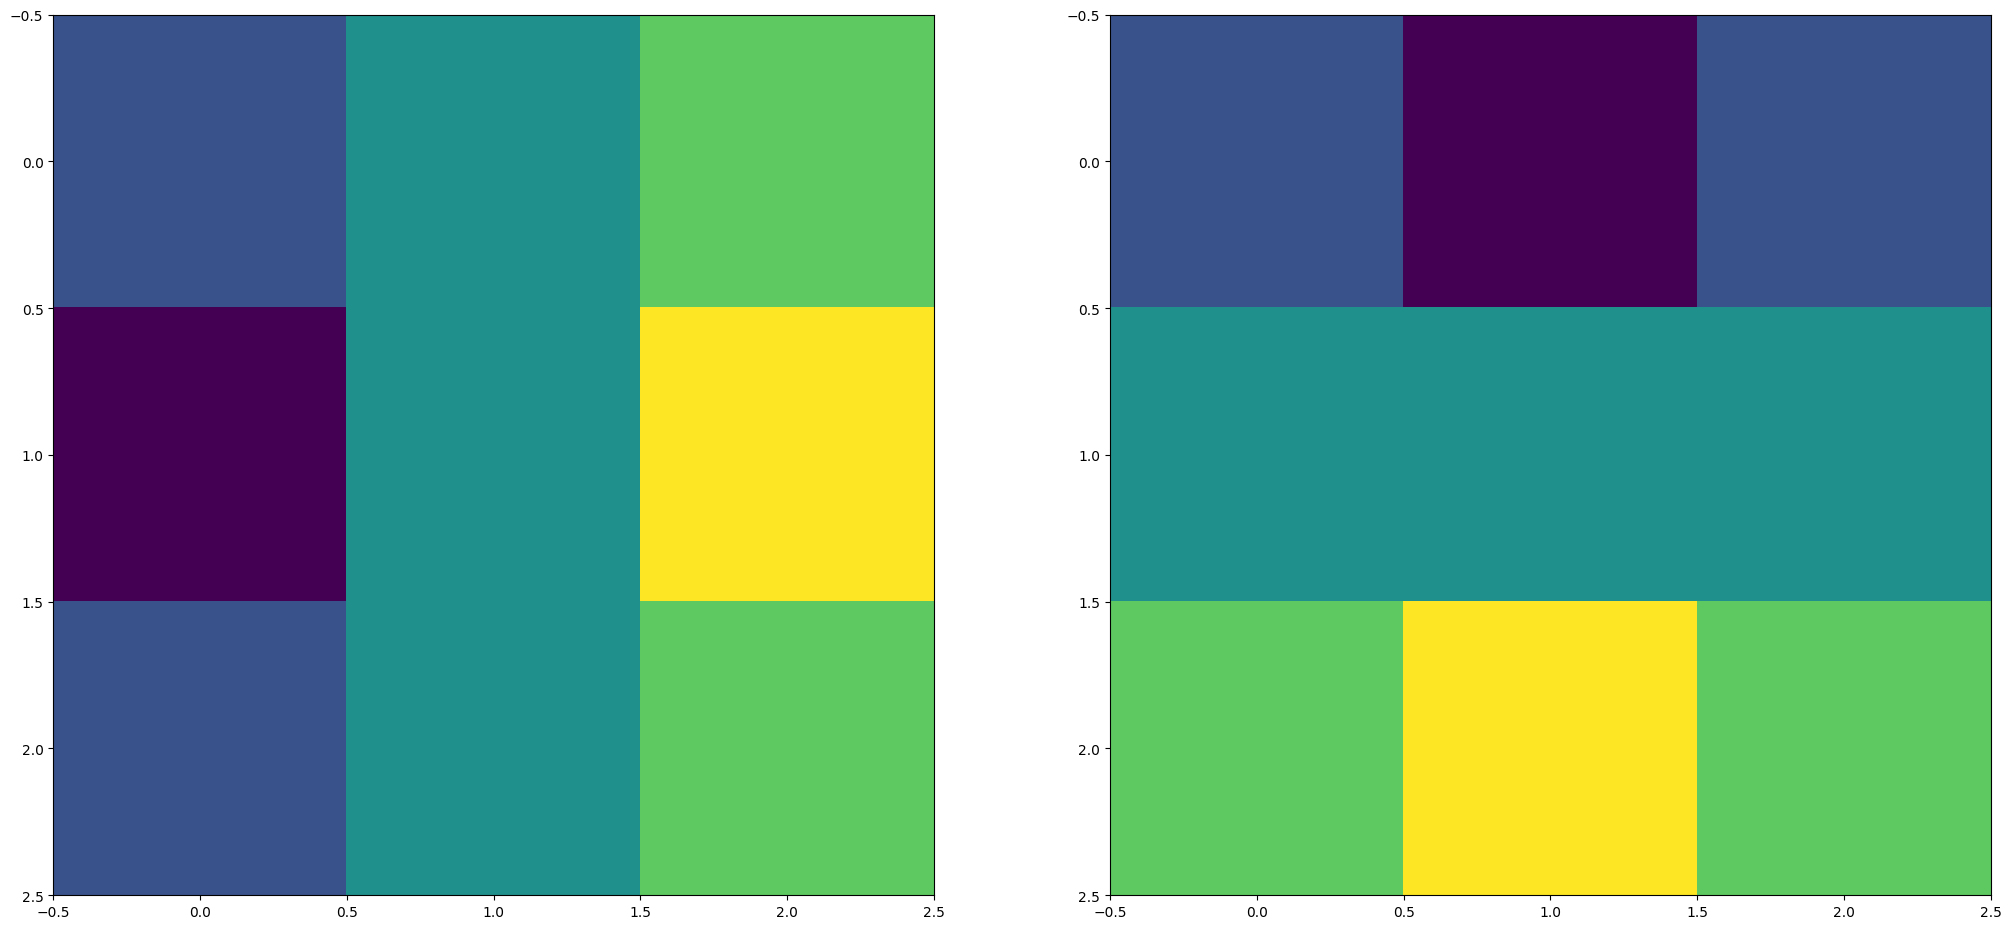

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
axes[0].imshow(kernel0)
axes[1].imshow(kernel1)

(366, 612, 3)


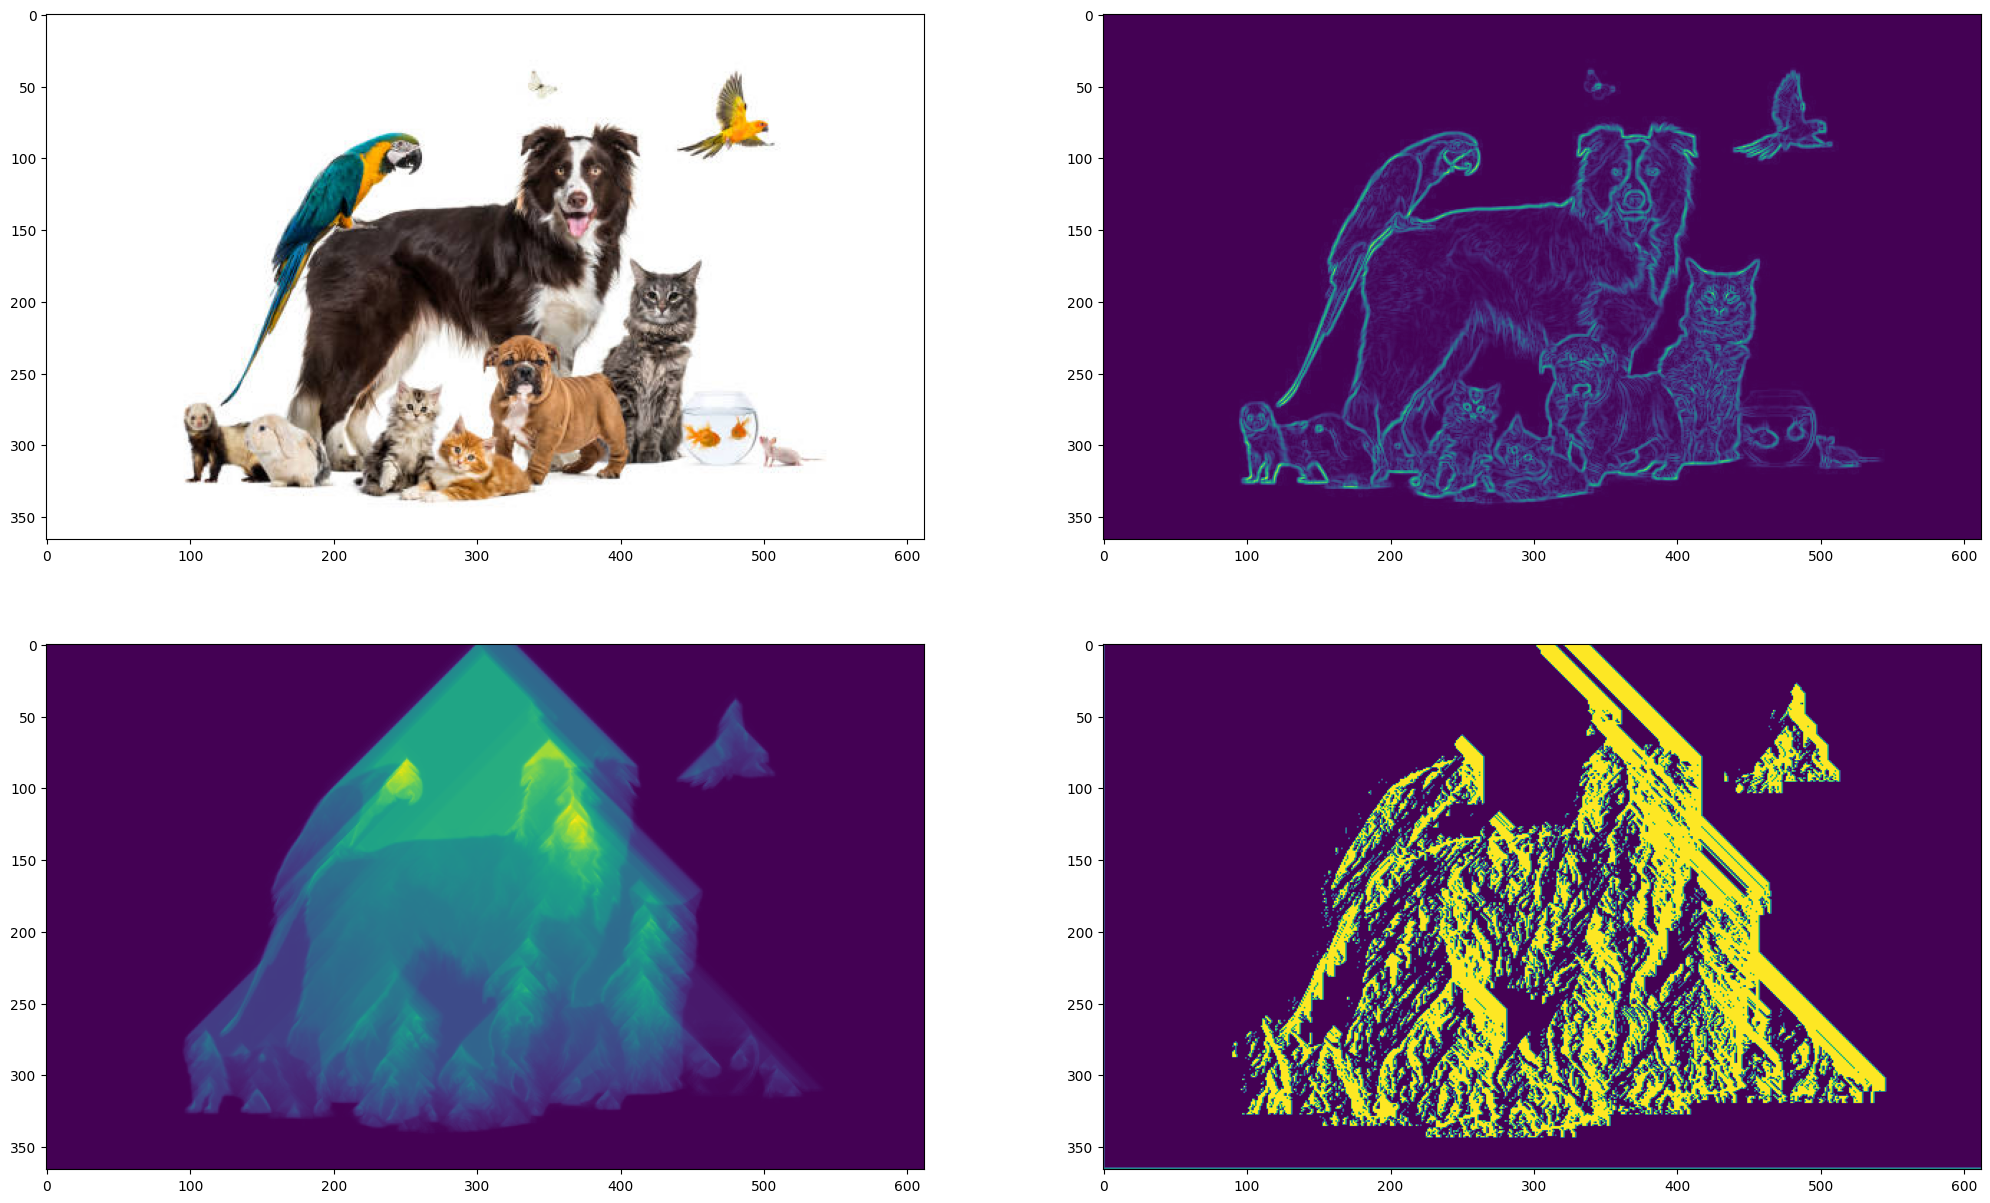

In [14]:
# imgorg = Image.open('../Cars/Original/00010.jpg')
imgorg = Image.open('img8.jpg')
imgorg = np.array(imgorg)
print(imgorg.shape)
img = brightness(imgorg)
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
edged = get_edgeness(img)
dp1, dirs1 = least_edgy_ver(edged)
dp2, dirs2 = least_edgy_hor(edged)
axes[0][0].imshow(imgorg)
axes[0][1].imshow(edged)
axes[1][0].imshow(dp1)
axes[1][1].imshow(dirs1)
# for i in range(len(dirs1)):
#     for j in range(len(dirs1[0])):
#         if 340<=j<=500:
#             if dirs1[i][j] == 1:
#                 print('⇘', end=' ')
#             elif dirs1[i][j] == -1:
#                 print('⇙', end=' ')
#             else:
#                 print('⇓', end=' ')

It took 5s to shrink horizontally by 184px and vertically by 110px


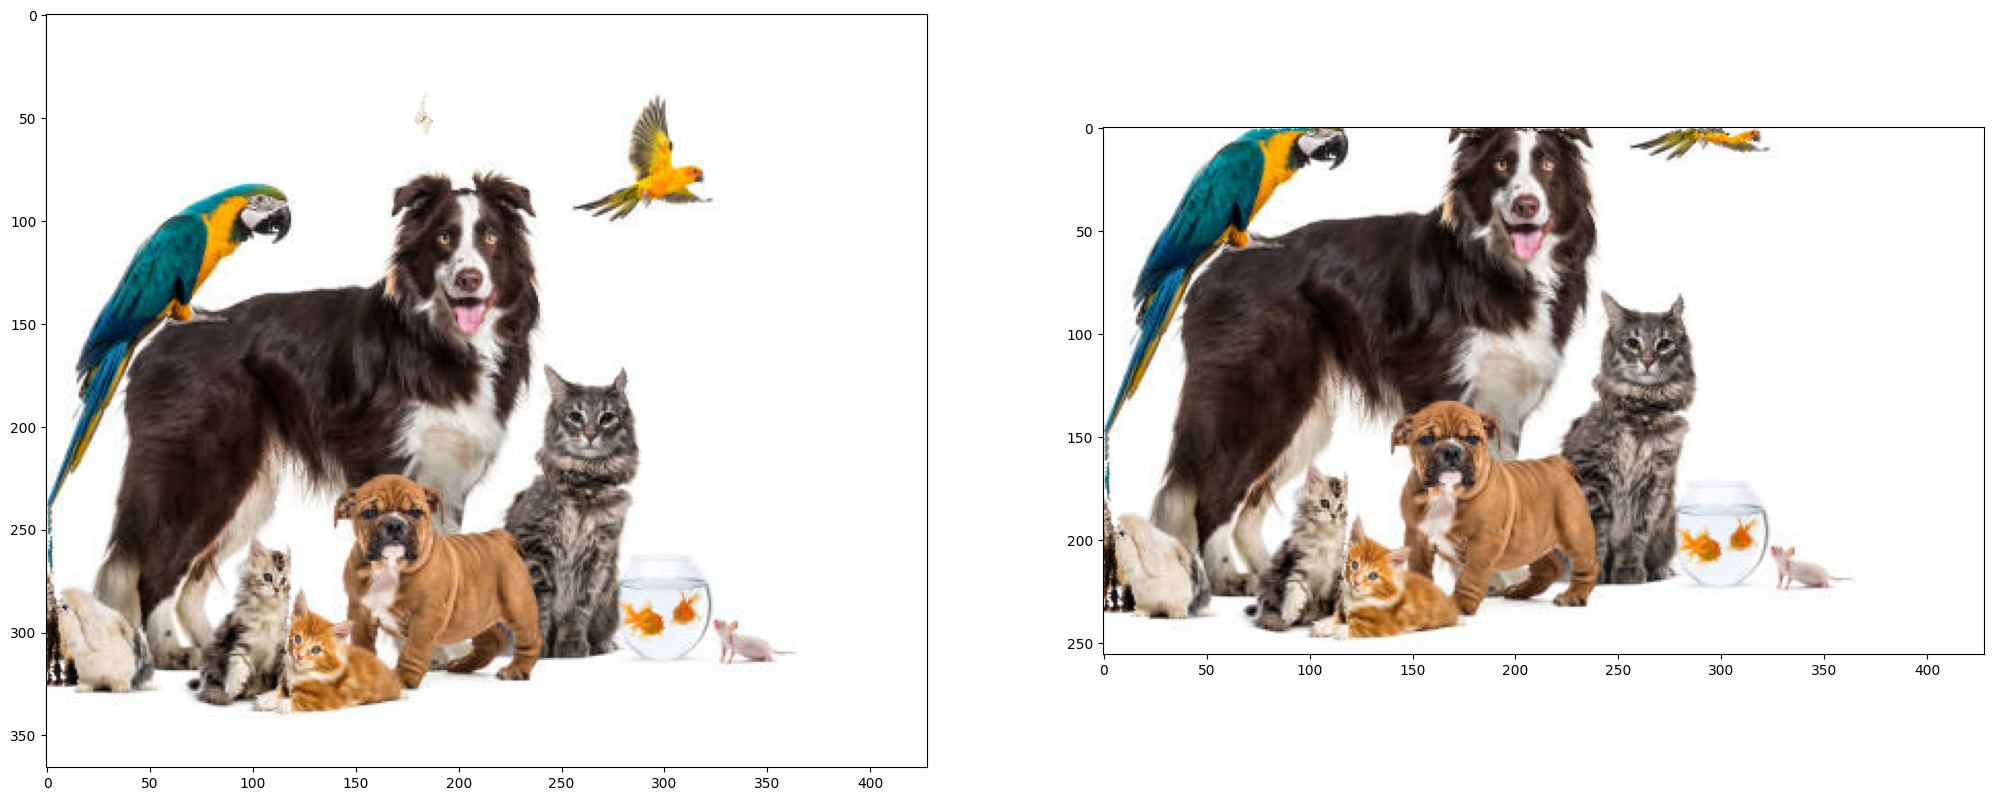

In [12]:
# horPx = img.shape[1] - 2
# verPx = img.shape[0] - 300
# processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
# processor.size = {'height': 330, 'width': 330}
# final = np.transpose(processor(imgorg, do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
scale = 0.3
horPx = round(img.shape[1] * scale)
verPx = round(img.shape[0] * scale)
# horPx = 330 - 224
# verPx = 330 -224
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
start = time.time() 
edged = get_edgeness(img)
img1 = shrink_horizontally(img,edged,imgorg,horPx)
edged = get_edgeness(img1[0])
img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
img_from_array = Image.fromarray(img2[1])
img_from_array.save("new_image.jpg")
axes[0].imshow(img1[1])
axes[1].imshow(img2[1])
end = time.time()
print("It took "+str(round(end - start))+"s to shrink horizontally by "+str(horPx)+"px and vertically by "+str(verPx)+"px")

In [162]:
# data1 = {"labels":[10, 20, 30, 40, 50], "images":[]}
# for per in data1["labels"]:
#     scale = per/100
#     horPx = round(img.shape[1] * scale)
#     verPx = round(img.shape[0] * scale)
#     edged = get_edgeness(img)
#     img1 = shrink_horizontally(img,edged,imgorg,horPx)
#     edged = get_edgeness(img1[0])
#     img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
#     final = np.transpose(processor(img2[1]).pixel_values[0], (1, 2, 0))
#     data1["images"].append(final)
# fig, axes = plt.subplots(3, 2, figsize=(10, 10))
# axes[0][0].imshow(data1["images"][0])
# axes[0][1].imshow(data1["images"][1])
# axes[1][0].imshow(data1["images"][2])
# axes[1][1].imshow(data1["images"][3])
# axes[2][0].imshow(data1["images"][4])


In [13]:
df = pd.read_csv('../Cars/stanford_cars_with_class_names - train.csv',header=0,encoding='utf-8')
df.head(5)
df = df[df['class'].isin([2,3,4,5,6])]
df.head()

,id,x1,y1,x2,y2,class,ture_class_name,image
45,669,97,49,455,326,2,Acura RL Sedan 2012,00670.jpg
46,690,84,189,573,376,2,Acura RL Sedan 2012,00691.jpg
47,857,139,416,1954,1149,2,Acura RL Sedan 2012,00858.jpg
48,1030,130,10,839,346,2,Acura RL Sedan 2012,01031.jpg
49,1033,115,63,817,324,2,Acura RL Sedan 2012,01034.jpg


In [14]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
count = 0
path = '../Cars/Original/'
savePath = '../Cars/Resized/Train/'
logfile = ""
start = time.time() 
# for file in os.listdir(path):
for file in df['image']:
    if file.split('.')[-1] != 'jpg':
        continue
    print("Processing file "+str(count+1)+":"+file)
    imgorg = Image.open(path+file)
    imgorg = np.array(imgorg)
    if len(imgorg.shape) <= 2:
        print("Image too small to process: "+file)
        logfile += "Image too small to process: "+file+"\n"
        count += 1
        continue
    if imgorg.shape[0] <= 224 or imgorg.shape[0] <= 224:
        final = np.transpose(processor(imgorg, do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
        img_from_array = Image.fromarray(final.astype(np.uint8))
        img_from_array.save(savePath+file.split('.')[0]+"_sc.jpg")
        logfile += "Image only BIL: "+file+"\n"
        count += 1
        continue
    img = brightness(imgorg)
    scale = 0.3
    horPx = round(img.shape[1] * scale)
    verPx = round(img.shape[0] * scale)
    edged = get_edgeness(img)
    img1 = shrink_horizontally(img,edged,imgorg,horPx)
    edged = get_edgeness(img1[0])
    img2 = shrink_vertically(img1[0],edged,img1[1],verPx)
    final = np.transpose(processor(img2[1], do_normalize=False, rescale_factor=1).pixel_values[0], (1, 2, 0))
    img_from_array = Image.fromarray(final.astype(np.uint8))
    img_from_array.save(savePath+file.split('.')[0]+"_sc.jpg")
    count += 1
end = time.time()

print("Time taken to process "+str(count + 1)+" images ~ "+str(round((end-start)/60))+" mins")

Processing file 1:00670.jpg
Processing file 2:00691.jpg
Processing file 3:00858.jpg


KeyboardInterrupt: 

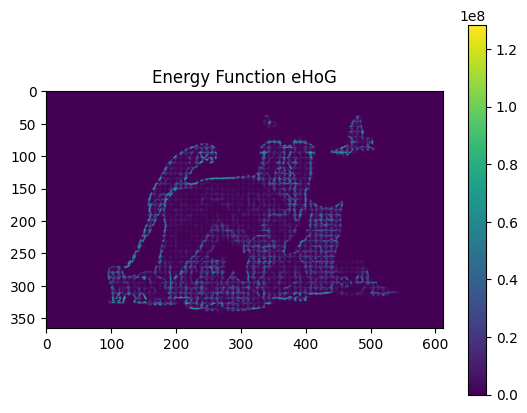

In [20]:
# Load the grayscale image
image = cv2.imread('img8.jpg', cv2.IMREAD_GRAYSCALE)

# Compute the gradients using Sobel filters
grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient along X
grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient along Y

# Calculate the gradient magnitude
gradient_magnitude = np.abs(grad_x) + np.abs(grad_y)
# Parameters for HoG
pixels_per_cell = (8, 8)  # Size of the local window
cells_per_block = (1, 1)
orientations = 9  # Number of gradient orientations

# Compute HoG features
hog_features, hog_image = hog(image,
                              orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              visualize=True,
                              block_norm='L2-Hys')

hog_resized = cv2.resize(hog_image, (image.shape[1], image.shape[0]))

# Calculate the energy function
e_hog = gradient_magnitude / (np.maximum(hog_resized, 1e-5))  # Avoid division by zero
plt.imshow(e_hog)
plt.colorbar()
plt.title('Energy Function eHoG')
plt.show()